In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


***Load libraries and data***

In [ ]:
!pip install transformers sentencepiece datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 74.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 49.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 108.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 19.2 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
from datasets import load_dataset
from google.colab import drive
from IPython.display import display
from IPython.html import widgets
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from torch import optim
from torch.nn import functional as F
from transformers import AdamW, AutoModelForSeq2SeqLM, AutoTokenizer
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm_notebook
import pandas as pd
from sklearn.model_selection import train_test_split

sns.set()

/usr/local/lib/python3.8/dist-packages/IPython/html.py:12: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  warn("The `IPython.html` package has been deprecated since IPython 4.0. "


In [ ]:
# Source: https://huggingface.co/datasets/alt
dataset = load_dataset("opus_books", "en-es")


Generating train split:   0%|          | 0/93470 [00:00<?, ? examples/s]

Dataset opus_books downloaded and prepared to /root/.cache/huggingface/datasets/opus_books/en-es/1.0.0/e8f950a4f32dc39b7f9088908216cd2d7e21ac35f893d04d39eb594746af2daf. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
dataset['train']['translation'][0]

{'en': 'Source: Project GutenbergAudiobook available here',
 'es': 'Source: Wikisource & librodot.com'}

In [ ]:
df = pd.DataFrame(data = dataset['train']['translation'],index=dataset['train']['id'])
df.columns=['target_text','input_text']
df['prefix']='<esp.eng>'
df = df.iloc[:,[1,2,0]]

In [ ]:
df

,input_text,prefix,target_text
0,Source: Wikisource & librodot.com,<esp.eng>,Source: Project GutenbergAudiobook available here
1,SENTIDO Y SENSIBILIDAD,<esp.eng>,Sense and Sensibility
2,JANE AUSTEN,<esp.eng>,Jane Austen
3,CAPITULO I,<esp.eng>,CHAPTER 1
4,La familia Dashwood llevaba largo tiempo afinc...,<esp.eng>,The family of Dashwood had long been settled i...
...,...,...,...
93465,Toda la compañía aprobó tan loable determinaci...,<esp.eng>,"The little society, one and all, entered into ..."
93466,"Verdad es que Cunegunda era muy fea, pero haci...",<esp.eng>,"Cunegund indeed was very ugly, but she became ..."
93467,"Hasta fray Hilarion sirvió, que aprendió con p...",<esp.eng>,"There was none, down to Brother Giroflee, but ..."
93468,Panglós deeia algunas veces á Candido. Todos l...,<esp.eng>,Pangloss used now and then to say to Candide: ...


In [ ]:
df.columns

Index(['input_text', 'prefix', 'target_text'], dtype='object')

In [ ]:
df = df.iloc[:,[1,0,2]]
df['input_text'] = df['prefix'] + ' ' + df['input_text'] 
df

,prefix,input_text,target_text
0,<esp.eng>,<esp.eng> Source: Wikisource & librodot.com,Source: Project GutenbergAudiobook available here
1,<esp.eng>,<esp.eng> SENTIDO Y SENSIBILIDAD,Sense and Sensibility
2,<esp.eng>,<esp.eng> JANE AUSTEN,Jane Austen
3,<esp.eng>,<esp.eng> CAPITULO I,CHAPTER 1
4,<esp.eng>,<esp.eng> La familia Dashwood llevaba largo ti...,The family of Dashwood had long been settled i...
...,...,...,...
93465,<esp.eng>,<esp.eng> Toda la compañía aprobó tan loable d...,"The little society, one and all, entered into ..."
93466,<esp.eng>,"<esp.eng> Verdad es que Cunegunda era muy fea,...","Cunegund indeed was very ugly, but she became ..."
93467,<esp.eng>,"<esp.eng> Hasta fray Hilarion sirvió, que apre...","There was none, down to Brother Giroflee, but ..."
93468,<esp.eng>,<esp.eng> Panglós deeia algunas veces á Candid...,Pangloss used now and then to say to Candide: ...


In [ ]:
# split the data into train and test set
train_df, eval_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

In [ ]:
train_df.shape

(74776, 3)

In [ ]:
eval_df.shape

(18694, 3)

In [ ]:
!pwd

/content


In [ ]:
train_df.to_csv("train.tsv", sep="\t")
eval_df.to_csv("eval.tsv", sep="\t")

In [ ]:
train_df = pd.read_csv("train.tsv", sep="\t", index_col=0).astype(str)
eval_df = pd.read_csv("eval.tsv", sep="\t",index_col=0).astype(str)

#train_df["prefix"] = ""
#eval_df["prefix"] = ""

In [ ]:
model_repo = 'google/mt5-base'
model_path = '/content/drive/MyDrive/translation/mt5_translation-3.pt'
max_seq_len = 40

**Load tokenizer and model**

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_repo)

/usr/local/lib/python3.8/dist-packages/transformers/convert_slow_tokenizer.py:446: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [ ]:
# Model description: https://huggingface.co/google/mt5-small
model = AutoModelForSeq2SeqLM.from_pretrained(model_repo)
model = model.cuda()

**Add prefixes to tokenizer**

In [ ]:
model.config.max_length=40

In [ ]:
len(tokenizer.vocab)

250100

In [ ]:
train_df['prefix'].unique()

array(['<esp.eng>'], dtype=object)

In [ ]:
LANG_TOKEN_MAPPING = {
    'esp.eng': '<esp.eng>'
}

In [ ]:
special_tokens_dict = {'additional_special_tokens': list(LANG_TOKEN_MAPPING.values())}
special_tokens_dict

{'additional_special_tokens': ['<esp.eng>']}

In [ ]:
tokenizer.add_special_tokens(special_tokens_dict)

1

In [ ]:
len(tokenizer)

250101

In [ ]:
tokenizer.all_special_tokens

['</s>', '<unk>', '<pad>', '<esp.eng>']

In [ ]:
model.config.vocab_size

250112

In [ ]:
model.resize_token_embeddings(len(tokenizer))

Embedding(250101, 768)

**Encoding functions**

In [ ]:
def encode_str(text, tokenizer, seq_len):  
#Tokenize,pad to max length and encode to ids Returns tensor with tocken ids
  input_ids = tokenizer.encode(
  text=text,
  return_tensors = 'pt',
  padding = 'max_length',
  truncation = True,
  max_length = seq_len)
  return input_ids[0]

In [ ]:
t1=encode_str('<esp.eng> This is a test',tokenizer, max_seq_len)
print(t1)
tokens = tokenizer.convert_ids_to_tokens(t1)
print(tokens)

tensor([250100,   1494,    339,    259,    262,   2978,      1,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0])
['<esp.eng>', '▁This', '▁is', '▁', 'a', '▁test', '</s>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [ ]:
def encode_row(row, tokenizer, seq_len):
  """Encode input and tagret texts from single row"""
  """Returns input and output tensors"""
  input_text = row['input_text']
  target_text = row['target_text']

  if input_text is None or target_text is None:
    return None

  input_token_ids = encode_str(
      input_text, tokenizer, seq_len)
  
  target_token_ids = encode_str(
      target_text, tokenizer, seq_len)

  return input_token_ids, target_token_ids


In [ ]:
def encode_batch(batch, tokenizer):
  """Encode a single batch"""
  """Returns input and output batch ids"""
  inputs = []
  targets = []
  for index, row in batch.iterrows():
    #gets input and output tocken ids
    formatted_data = encode_row(
        row, tokenizer, max_seq_len)
#    print("i/o tocken ids:",formatted_data)    
    if formatted_data is None:
      continue
    
    input_ids, target_ids = formatted_data
    #unsqueeze(input, dim) returns a new tensor with a dimension of size one inserted at the specified position
    inputs.append(input_ids.unsqueeze(0))
    targets.append(target_ids.unsqueeze(0))
#  print('squeezed tocken ids:',inputs,targets)

#Concatenate the given sequence of seq tensors in the given dimension    
  batch_input_ids = torch.cat(inputs).cuda()
  batch_target_ids = torch.cat(targets).cuda()

  return batch_input_ids, batch_target_ids

In [ ]:
def data_generator(dataset, tokenizer, batch_size=32):
  """"generates batches"""
  #shuffle the data
  dataset=dataset.sample(frac=1).reset_index(drop=True)

  for i in range(0, len(dataset), batch_size):
    raw_batch = dataset[i:i+batch_size]
    yield encode_batch(raw_batch, tokenizer)

In [ ]:
# Testing data generator
data_gen = data_generator(train_df, tokenizer, 8)
data_batch = next(data_gen)
#print('data_batch:',data_batch)
print('Input shape:', data_batch[0].shape)
print('Output shape:', data_batch[1].shape)


Input shape: torch.Size([8, 40])
Output shape: torch.Size([8, 40])


**Load the weights (post-training part)**

In [ ]:
model.load_state_dict(torch.load(model_path))

**Training**

In [ ]:
n_epochs = 1
batch_size = 8
print_freq = 1000
checkpoint_freq = 10000
lr = 5e-4 
n_batches = int(np.ceil(len(train_df) / batch_size)) #number of interations : 100000
total_steps = n_epochs * n_batches 
n_warmup_steps = int(total_steps * 0.01) 


In [ ]:
int(np.ceil(len(train_df) / batch_size))

9347

In [ ]:
# Optimizer
optimizer = AdamW(model.parameters(), lr=lr)
# Create a schedule with a learning rate that decreases linearly from the initial lr set in the optimizer to 0, 
# after a warmup period during which it increases linearly from 0 to the initial lr set in the optimizer.
# Warm up steps is a parameter which is used to lower the learning rate 
# in order to reduce the impact of deviating the model from learning on sudden new data set exposure.
scheduler = get_linear_schedule_with_warmup(
    optimizer, n_warmup_steps, total_steps)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
losses = []

In [ ]:
def eval_model(model, dataset, max_iters=10):
  """evaluate the model on small test data"""
  test_generator = data_generator(dataset,
                                      tokenizer, batch_size)
  eval_losses = []
  for i, (input_batch, label_batch) in enumerate(test_generator):
    if i >= max_iters:
      break

    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)
    eval_losses.append(model_out.loss.item())
    

  return np.mean(eval_losses)

In [ ]:
for epoch_idx in range(n_epochs):
  # generate batch data
  data_generator = data_generator(train_df,
                                      tokenizer, batch_size)
                
  for batch_idx, (input_batch, label_batch) \
      in tqdm_notebook(enumerate(data_generator), total=n_batches):
    #zeroes all the gradients before the calculation
    optimizer.zero_grad()

    # Forward pass
    model_out = model.forward(
        input_ids = input_batch,
        labels = label_batch)

    # Calculate loss
    loss = model_out.loss
    # loss.item() gets the scalar value held in the loss.  item() turns a Tensor into a Python number
    losses.append(loss.item())
    #backpropagation - computing the gradient of the loss function with respect to each weight
    loss.backward()
    # updating weights to minimize loss
    optimizer.step()
    #You call scheduler.step() every batch, right after optimizer.step(), to update the learning rate.
    scheduler.step()

    # Print training update info
    # every 1000 batches
    if (batch_idx + 1) % print_freq == 0:
      #average loss for the last 1000 batches
      avg_loss = np.mean(losses[-print_freq:])
      print('Epoch: {} | Step: {} | Avg. loss: {:.3f} | lr: {}'.format(
          epoch_idx+1, batch_idx+1, avg_loss, scheduler.get_last_lr()[0]))

    #every 10000 batches save the model 
    if (batch_idx + 1) % checkpoint_freq == 0:
      test_loss = eval_model(model, eval_df)
      print('Saving model with test loss of {:.3f}'.format(test_loss))
      torch.save(model.state_dict(), model_path)

torch.save(model.state_dict(), model_path)
model.save_pretrained(model_path)

<ipython-input-41-1e47ae23c25e>:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  in tqdm_notebook(enumerate(data_generator), total=n_batches):


  0%|          | 0/9347 [00:00<?, ?it/s]

Epoch: 1 | Step: 1000 | Avg. loss: 3.047 | lr: 0.0004509941646855414
Epoch: 1 | Step: 2000 | Avg. loss: 1.724 | lr: 0.0003969634752539443
Epoch: 1 | Step: 3000 | Avg. loss: 1.580 | lr: 0.0003429327858223471
Epoch: 1 | Step: 4000 | Avg. loss: 1.511 | lr: 0.00028890209639074993
Epoch: 1 | Step: 5000 | Avg. loss: 1.462 | lr: 0.00023487140695915279
Epoch: 1 | Step: 6000 | Avg. loss: 1.436 | lr: 0.00018084071752755566
Epoch: 1 | Step: 7000 | Avg. loss: 1.415 | lr: 0.00012681002809595852
Epoch: 1 | Step: 8000 | Avg. loss: 1.373 | lr: 7.277933866436135e-05
Epoch: 1 | Step: 9000 | Avg. loss: 1.318 | lr: 1.874864923276421e-05


Provided path (/content/drive/MyDrive/translation/mt5_translation-3.pt) should be a directory, not a file


In [ ]:
model.save_pretrained('/content/drive/MyDrive/translation/')

In [ ]:
import gc
#del model
gc.collect()

torch.cuda.empty_cache()

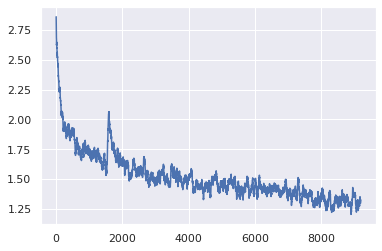

In [ ]:
# Graph the loss

window_size = 50
smoothed_losses = []
for i in range(len(losses)-window_size):
  smoothed_losses.append(np.mean(losses[i:i+window_size]))

plt.plot(smoothed_losses[100:])

**Manual testing**

In [ ]:
test_sentence = eval_df['input_text'].iloc[3]
#test_sentence="<eng.ger> i had an awful meeting with my boss"
print('Raw input text:', test_sentence)

input_ids = encode_str(
    text = test_sentence,
    tokenizer = tokenizer,
    seq_len = model.config.max_length)
input_ids = input_ids.unsqueeze(0).cuda()

print('Truncated input text:', tokenizer.convert_tokens_to_string(
    tokenizer.convert_ids_to_tokens(input_ids[0])))

Raw input text: <esp.eng> Lo contemplé con un sentimiento de horror.
Truncated input text: <esp.eng> Lo contemplé con un sentimiento de horror.</s><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>


In [ ]:
output_tokens = model.generate(input_ids, num_beams=10, num_return_sequences=3, length_penalty = 1, no_repeat_ngram_size=2)
# print(output_tokens)
for token_set in output_tokens:
  print(token_set, tokenizer.decode(token_set,skip_special_tokens=True))

/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1186: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use a generation configuration file (see https://huggingface.co/docs/transformers/main_classes/text_generation)
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/transformers/generation/utils.py:1273: UserWarning: Neither `max_length` nor `max_new_tokens` has been set, `max_length` will default to 40 (`generation_config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


tensor([    0,   336,  4089,   345,   344,  4065,   514,   259,   262, 28478,
          304, 85224,   260,     1], device='cuda:0') I looked at him with a feeling of horror.
tensor([    0,   336,  4089,   345,   344,  4065,   514,   259,   262, 13336,
          304, 85224,   260,     1], device='cuda:0') I looked at him with a sense of horror.
tensor([    0,   336,  4089,   345,   344,   609,   514,   259,   262, 28478,
          304, 85224,   260,     1], device='cuda:0') I looked at it with a feeling of horror.


In [ ]:
!pip install sacrebleu
import sacrebleu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 KB 6.2 MB/s eta 0:00:00


In [ ]:
#@title Translator
input_text = 'La otra noche tuve una horrible experiencia, en mis sue\xF1os' #@param {type:"string"}
output_language = '\u003Cesp.eng>' #@param ["<esp.eng>"]

input_ids = encode_str(
    text = output_language+input_text,
    tokenizer = tokenizer,
    seq_len = model.config.max_length
    )
input_ids = input_ids.unsqueeze(0).cuda()
print(input_ids)
output_tokens = model.generate(input_ids,num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
print(input_text + '  ->  ' + \
      tokenizer.decode(output_tokens[0], skip_special_tokens=True))

**Flask App**

requires upload to templates and static folders

In [ ]:
!pip install flask-ngrok



In [ ]:

from flask import Flask, render_template, request
from flask_ngrok import run_with_ngrok
app = Flask(__name__)
run_with_ngrok(app)   


@app.route('/')
def index():
    
    return render_template('index.html', title='Welcome  to  mT5-Translator')

@app.route('/translate',methods=["POST"])
def translate():
    input = dict(request.form)
 

    TEXT=list(input.values())[1]
    FROM=list(input.keys())[0]
    TO=list(input.keys())[2]



    input_text = str(TEXT)
    language = '<'+str(FROM)+'>'
    print(language,input_text)
    input_ids = encode_str(
        text = language+input_text,
        tokenizer = tokenizer,
        seq_len = max_seq_len
        )
    input_ids = input_ids.unsqueeze(0).cuda()
    print(input_ids)
    output_tokens = model.generate(input_ids,num_beams=10, num_return_sequences=1, length_penalty = 1, no_repeat_ngram_size=2)
    
    TRANS=tokenizer.decode(output_tokens[0], skip_special_tokens=True)
#    TRANS='your translation'


    return render_template('translate.html', text=input_text, trans=TRANS )
    
app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://5e52cc5b8d01.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


127.0.0.1 - - [03/Aug/2021 13:27:16] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:27:16] "GET /static/style.css HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:27:16] "GET /static/image3.gif HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:27:16] "GET /static/google2.png HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:27:17] "GET /static/google.png HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:27:18] "GET /favicon.ico HTTP/1.1" 404 -


<eng.ger> I built a language translator using deep learning
tensor([[250103,    336,    259,  22961,    259,    262,  17896,    259, 159095,
            259,   4342,  24682,  22651,      1,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:42:09] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:42:09] "GET /static/unnamed.png HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:42:18] "GET / HTTP/1.1" 200 -


<ger.eng> Ich habe einen Sprachübersetzer mit Hilfe von Deep Learning entwickelt.
tensor([[250102,   4824,   6247,    259,   2448,  92439,  19365,   2325,   3885,
            749,    259,  41034,    795,  29188,  48162,    259,  42654,    270,
            260,      1,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:42:25] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:42:34] "GET / HTTP/1.1" 200 -


<eng.rus> I developed a language translator with the help of Deep Learning.
tensor([[250101,    336,    259,  36260,    259,    262,  17896,    259, 159095,
            514,    287,   2114,    304,  29188,  48162,    260,      1,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:42:48] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:43:00] "GET / HTTP/1.1" 200 -


<rus.eng> Я разработал языковой переводчик с помощью Deep Learning.
tensor([[250100,   2553,  26494,   3725,  11183,   8050,  43898,  19965,    388,
           8465,   4722,  29188,  48162,    260,      1,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:43:07] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:43:11] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:45:48] "GET / HTTP/1.1" 200 -


<eng.ger> I built a language translator using deep learning
tensor([[250103,    336,    259,  22961,    259,    262,  17896,    259, 159095,
            259,   4342,  24682,  22651,      1,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:55:06] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:55:14] "GET / HTTP/1.1" 200 -


<ger.eng> Ich habe einen Sprachübersetzer mit Hilfe von Deep Learning entwickelt.
tensor([[250102,   4824,   6247,    259,   2448,  92439,  19365,   2325,   3885,
            749,    259,  41034,    795,  29188,  48162,    259,  42654,    270,
            260,      1,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:55:19] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:55:25] "GET / HTTP/1.1" 200 -


<eng.rus> I developed a language translator with the help of Deep Learning.
tensor([[250101,    336,    259,  36260,    259,    262,  17896,    259, 159095,
            514,    287,   2114,    304,  29188,  48162,    260,      1,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:55:31] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:55:36] "GET / HTTP/1.1" 200 -


<rus.eng> Я разработал языковой переводчик с помощью Deep Learning.
tensor([[250100,   2553,  26494,   3725,  11183,   8050,  43898,  19965,    388,
           8465,   4722,  29188,  48162,    260,      1,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 13:55:42] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:55:45] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 13:59:15] "GET / HTTP/1.1" 200 -


<eng.ger> I built a language translator using deep learning
tensor([[250103,    336,    259,  22961,    259,    262,  17896,    259, 159095,
            259,   4342,  24682,  22651,      1,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:08:29] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:08:39] "GET / HTTP/1.1" 200 -


<ger.eng> Ich habe einen Sprachübersetzer mit Hilfe von Deep Learning entwickelt.
tensor([[250102,   4824,   6247,    259,   2448,  92439,  19365,   2325,   3885,
            749,    259,  41034,    795,  29188,  48162,    259,  42654,    270,
            260,      1,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:08:47] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:08:54] "GET / HTTP/1.1" 200 -


<eng.rus> I developed a language translator with the help of Deep Learning.
tensor([[250101,    336,    259,  36260,    259,    262,  17896,    259, 159095,
            514,    287,   2114,    304,  29188,  48162,    260,      1,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:09:01] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:09:09] "GET / HTTP/1.1" 200 -


<rus.eng> Я разработал языковой переводчик с помощью Deep Learning.
tensor([[250100,   2553,  26494,   3725,  11183,   8050,  43898,  19965,    388,
           8465,   4722,  29188,  48162,    260,      1,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:09:19] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:09:22] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:19:29] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:19:31] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:23:12] "GET / HTTP/1.1" 200 -


<eng.ger> Please specify desired languages and enter your text


tensor([[250103,    259,   9560, 104488,    276,  44776,    345,    259, 100568,
            305,  21548,    772,   7461,    259,      1,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:23:23] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:23:26] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:26:02] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:33:09] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:33:13] "GET / HTTP/1.1" 200 -


<eng.ger> I built a language translator using deep learning
tensor([[250103,    336,    259,  22961,    259,    262,  17896,    259, 159095,
            259,   4342,  24682,  22651,      1,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:46:39] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:46:53] "GET / HTTP/1.1" 200 -


<ger.eng> Ich habe einen Sprachübersetzer mit Hilfe von Deep Learning entwickelt.
tensor([[250102,   4824,   6247,    259,   2448,  92439,  19365,   2325,   3885,
            749,    259,  41034,    795,  29188,  48162,    259,  42654,    270,
            260,      1,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:47:00] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:47:11] "GET / HTTP/1.1" 200 -


<eng.rus> I developed a language translator with the help of Deep Learning.
tensor([[250101,    336,    259,  36260,    259,    262,  17896,    259, 159095,
            514,    287,   2114,    304,  29188,  48162,    260,      1,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0,      0,      0,      0,      0,      0,
              0,      0,      0,      0]], device='cuda:0')


127.0.0.1 - - [03/Aug/2021 14:47:21] "POST /translate HTTP/1.1" 200 -
127.0.0.1 - - [03/Aug/2021 14:47:29] "GET / HTTP/1.1" 200 -
